In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# CNN1

In [16]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 128)               1032320   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1034499 (3.95 MB)
Trainable params: 1034499 (3.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 4s 75ms/step - loss: 1.0588 - accuracy: 0.5193 - val_loss: 0.7668 - val_accuracy: 0.6511
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.6159 - accuracy: 0.7820 - val_loss: 0.4630 - val_accuracy: 0.8570
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.3967 - accuracy: 0.8810 - val_loss: 0.3230 - val_accuracy: 0.8945
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.2580 - accuracy: 0.9349 - val_loss: 0.1892 - val_accuracy: 0.9523
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.1627 - accuracy: 0.9629 - val_loss: 0.1118 - val_accuracy: 0.9757
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.1019 - accuracy: 0.9808 - val_loss: 0.0703 - val_accuracy: 0.9878
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0676 - accuracy: 0.9878 - val_loss: 0.0463 - val_accuracy: 0.9929
Epoch 8/10
26

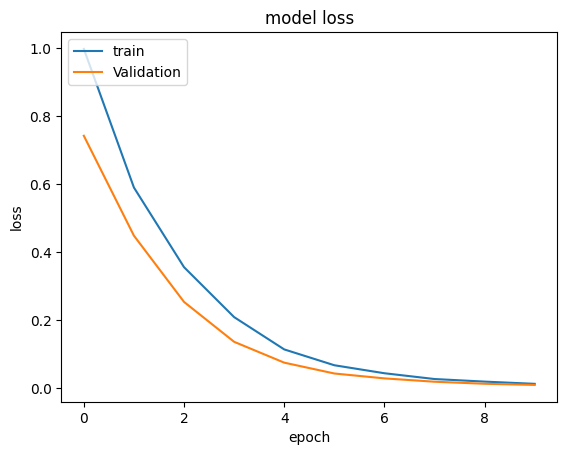

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

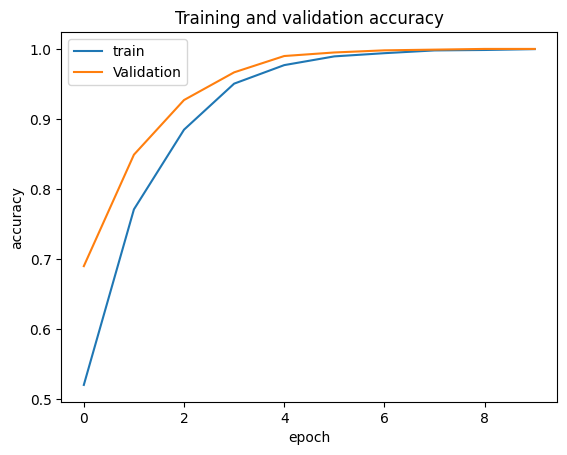

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 6ms/step
[[452   4  40]
 [  4 438  29]
 [  5   6 409]]
0.9365537130497477
0.9373296752360754
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       496
           1       0.98      0.93      0.95       471
           2       0.86      0.97      0.91       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

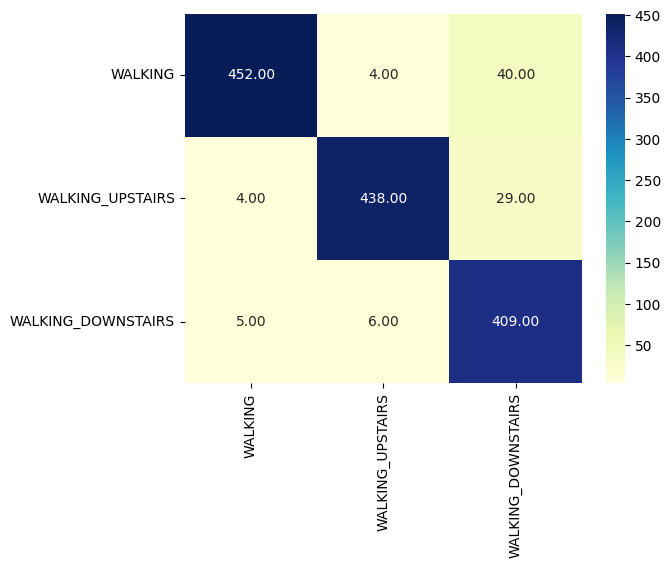

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 2


In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1015936   
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1030467 (3.93 MB)
Trainable params: 1030467 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 3s 94ms/step - loss: 1.0594 - accuracy: 0.4907 - val_loss: 0.8196 - val_accuracy: 0.6886
Epoch 2/10
26/26 [==============================] - 2s 73ms/step - loss: 0.5717 - accuracy: 0.8149 - val_loss: 0.3460 - val_accuracy: 0.9026
Epoch 3/10
26/26 [==============================] - 2s 73ms/step - loss: 0.1983 - accuracy: 0.9562 - val_loss: 0.0911 - val_accuracy: 0.9838
Epoch 4/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0661 - accuracy: 0.9866 - val_loss: 0.0567 - val_accuracy: 0.9878
Epoch 5/10
26/26 [==============================] - 2s 87ms/step - loss: 0.0354 - accuracy: 0.9933 - val_loss: 0.0232 - val_accuracy: 0.9959
Epoch 6/10
26/26 [==============================] - 3s 116ms/step - loss: 0.0183 - accuracy: 0.9967 - val_loss: 0.0110 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0090 - accuracy: 0.9991 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 8/10
2

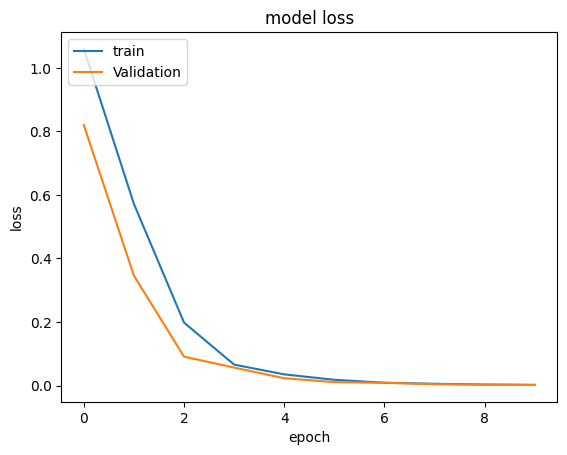

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

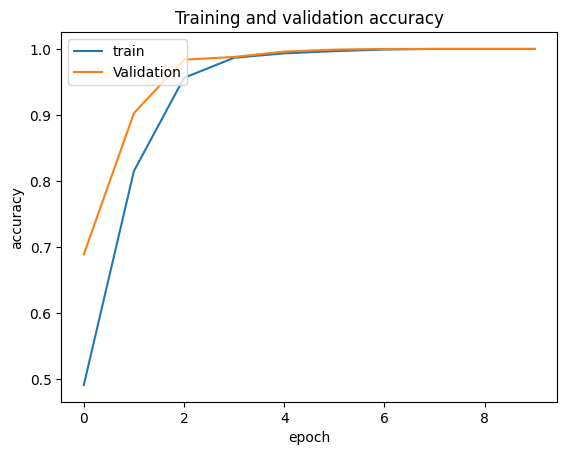

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 6ms/step
[[459   6  31]
 [  1 439  31]
 [  3   1 416]]
0.9473684210526315
0.9480132342750129
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       496
           1       0.98      0.93      0.96       471
           2       0.87      0.99      0.93       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

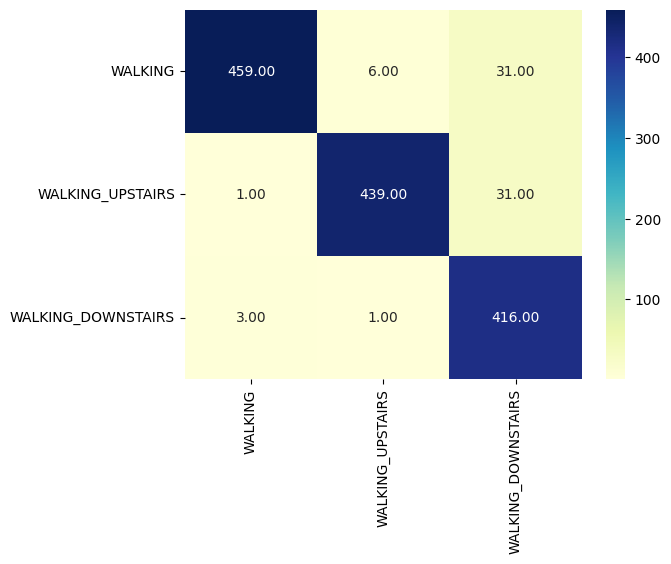

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 flatten_2 (Flatten)         (None, 7808)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               999552    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1026435 (3.92 MB)
Trainable params: 1026

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 4s 114ms/step - loss: 1.0061 - accuracy: 0.4779 - val_loss: 0.6765 - val_accuracy: 0.6440
Epoch 2/10
26/26 [==============================] - 3s 121ms/step - loss: 0.5160 - accuracy: 0.7912 - val_loss: 0.3152 - val_accuracy: 0.8986
Epoch 3/10
26/26 [==============================] - 4s 157ms/step - loss: 0.1885 - accuracy: 0.9504 - val_loss: 0.0755 - val_accuracy: 0.9828
Epoch 4/10
26/26 [==============================] - 3s 101ms/step - loss: 0.0581 - accuracy: 0.9863 - val_loss: 0.0329 - val_accuracy: 0.9939
Epoch 5/10
26/26 [==============================] - 3s 106ms/step - loss: 0.0212 - accuracy: 0.9957 - val_loss: 0.0257 - val_accuracy: 0.9909
Epoch 6/10
26/26 [==============================] - 3s 104ms/step - loss: 0.0094 - accuracy: 0.9991 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 4s 148ms/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 

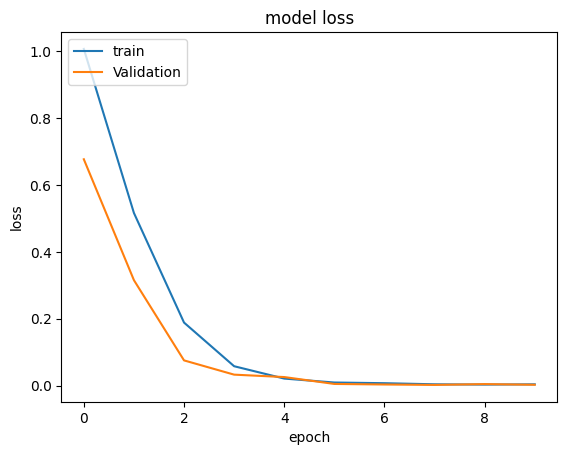

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

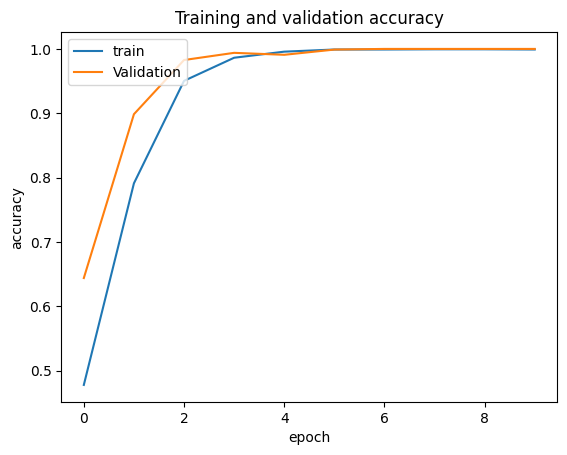

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 8ms/step
[[456   8  32]
 [  3 439  29]
 [  1   3 416]]
0.9452054794520548
0.9457437184538068
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       496
           1       0.98      0.93      0.95       471
           2       0.87      0.99      0.93       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.94      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

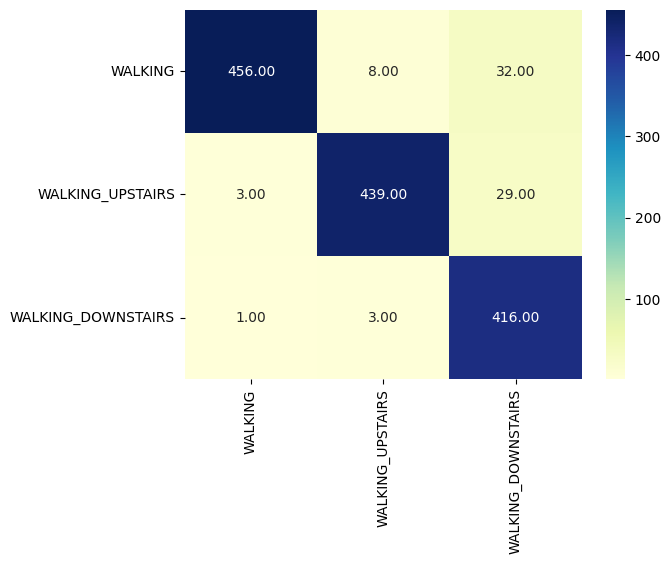

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN4

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_7 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_8 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 conv1d_9 (Conv1D)           (None, 120, 64)           12352     
                                                                 
 flatten_3 (Flatten)         (None, 7680)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               983168    
                                                                 
 dense_7 (Dense)             (None, 3)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 208ms/step - loss: 0.7522 - accuracy: 0.6721 - val_loss: 0.5402 - val_accuracy: 0.7576
Epoch 2/10
26/26 [==============================] - 3s 131ms/step - loss: 0.2335 - accuracy: 0.9227 - val_loss: 0.0553 - val_accuracy: 0.9919
Epoch 3/10
26/26 [==============================] - 3s 132ms/step - loss: 0.0591 - accuracy: 0.9839 - val_loss: 0.0525 - val_accuracy: 0.9828
Epoch 4/10
26/26 [==============================] - 4s 165ms/step - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.0163 - val_accuracy: 0.9970
Epoch 5/10
26/26 [==============================] - 8s 308ms/step - loss: 0.0111 - accuracy: 0.9982 - val_loss: 0.0047 - val_accuracy: 0.9990
Epoch 6/10
26/26 [==============================] - 3s 128ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 3s 128ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 

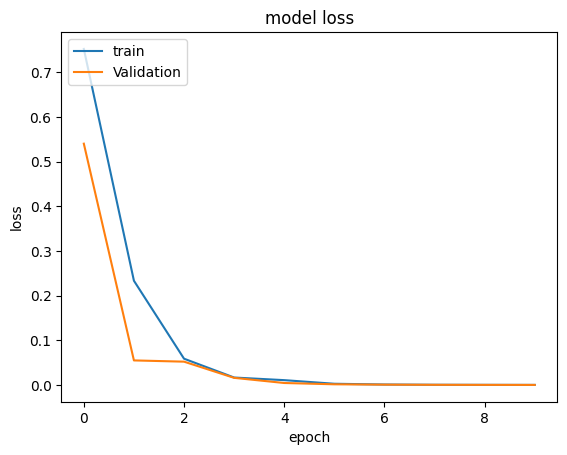

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

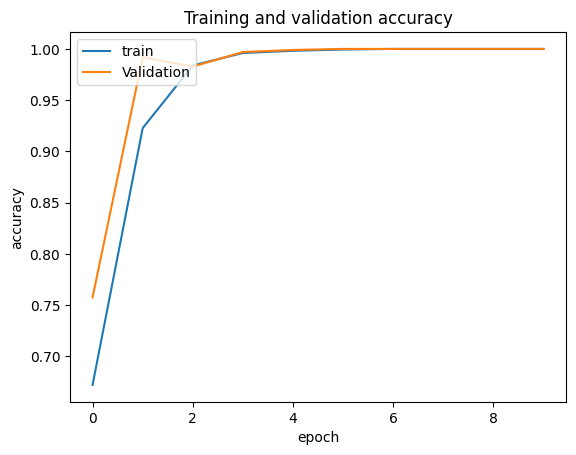

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 10ms/step
[[464  21  11]
 [ 17 426  28]
 [  4   3 413]]
0.93943763518385
0.9392647772000612
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.95      0.90      0.93       471
           2       0.91      0.98      0.95       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

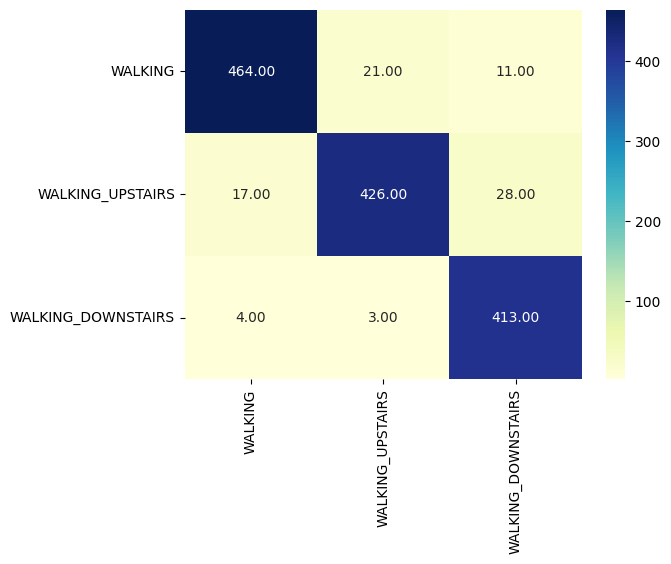

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN5

In [18]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 120, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 118, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 7552)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 14s 388ms/step - loss: 0.8257 - accuracy: 0.6189 - val_loss: 0.3750 - val_accuracy: 0.8682
Epoch 2/10
26/26 [==============================] - 7s 272ms/step - loss: 0.2195 - accuracy: 0.9254 - val_loss: 0.0991 - val_accuracy: 0.9665
Epoch 3/10
26/26 [==============================] - 6s 234ms/step - loss: 0.0527 - accuracy: 0.9854 - val_loss: 0.0370 - val_accuracy: 0.9899
Epoch 4/10
26/26 [==============================] - 4s 162ms/step - loss: 0.0161 - accuracy: 0.9957 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 5/10
26/26 [==============================] - 4s 142ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 4s 155ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 6s 244ms/step - loss: 6.6210e-04 - accuracy: 1.0000 - val_loss: 5.3760e-04 - val_accuracy: 1.00

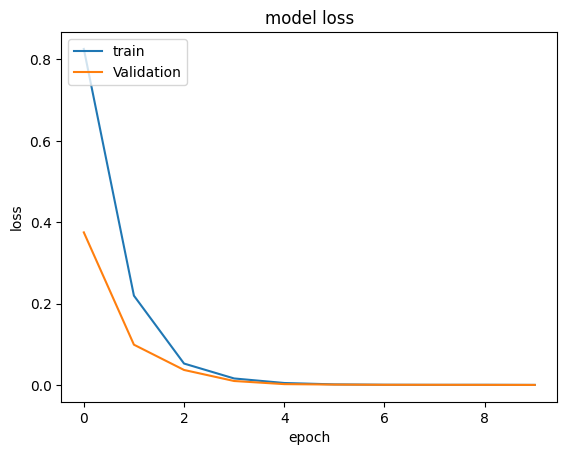

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

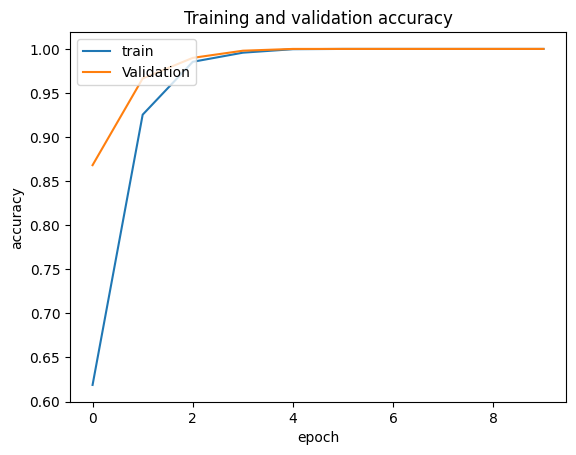

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 19ms/step
[[464   3  29]
 [  2 433  36]
 [  0   4 416]]
0.946647440519106
0.9473972245040987
              precision    recall  f1-score   support

           0       1.00      0.94      0.96       496
           1       0.98      0.92      0.95       471
           2       0.86      0.99      0.92       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

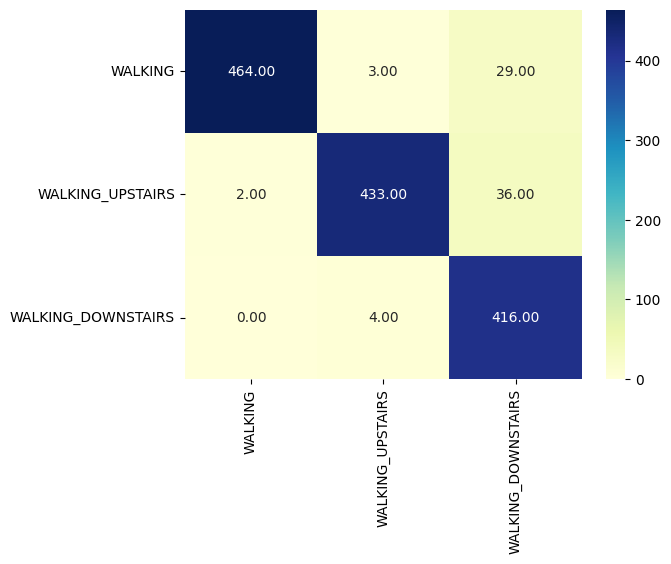

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')